# Task 2 Encoding and Classifier

## Description

- Encode the following files in a quantum circuit [mock_train_set.csv](https://drive.google.com/file/d/1PIcC1mJ_xi4u1-2gxyoStg2Rg_joSBIB/view?usp=sharing) and [mock_test_set.csv](https://drive.google.com/file/d/1aapYE69pTeNHZ6u-qKAoLfd1HWZVWPlB/view?usp=sharing) in at least two different ways (these could be basis, angle, amplitude, kernel or random encoding).
- Design a variational quantum circuit for each of the encodings, using the `column4` as the target, this is a binary class 0 and 1.
- You must use the data from `column0` to `column3` for your proposed classifier.
- Consider the ansatz you are going to design as a layer and find out how many layers are necessary to reach the best performance.

Analyze and discuss the results.

Feel free to use existing frameworks (e.g. PennyLane, Qiskit) for creating and training the circuits.  
This PennyLane demo can be useful: [Training a quantum circuit with Pytorch](https://pennylane.ai/qml/demos/tutorial_state_preparation.html).  
This Quantum Tensorflow tutorial can be useful: [Training a quantum circuit with Tensorflow](https://www.tensorflow.org/quantum/tutorials/mnist).

For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RZ and CNOTs.

In [82]:
# Added to silence some warnings.
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import numpy as np
import pandas as pd
import pennylane as qml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## EDA
First, let's load and preprocess the data.

In [53]:
train_data = pd.read_csv("data/mock_train_set.csv")
test_data = pd.read_csv("data/mock_test_set.csv")

print(f"Shape of train data: {train_data.shape}")
print(f"Shape of test data: {test_data.shape}")

Shape of train data: (300, 5)
Shape of test data: (120, 5)


Let's take a closer look at the data, its contents, and data types.

In [54]:
train_data.head()

,0,1,2,3,4
0,2789.26,1000.0,10.0,20.0,0.0
1,4040.01,1000000.0,1.0,1.0,1.0
2,2931.20,10000.0,10000.0,40.0,1.0
3,3896.54,10000.0,100000.0,30.0,1.0
4,982.06,100.0,1000.0,75.0,0.0


In [55]:
test_data.head()

,0,1,2,3,4
0,2988.55,10000.0,10000.0,75.0,1.0
1,3413.80,1.0,100.0,90.0,0.0
2,3891.52,1.0,1.0,5.0,0.0
3,4514.99,10000.0,1000000.0,25.0,1.0
4,752.29,10.0,10.0,90.0,0.0


In [56]:
print(train_data.info())
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
 2   2       300 non-null    float64
 3   3       300 non-null    float64
 4   4       300 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB
None


,0,1,2,3,4
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2630.877933,308630.410000,127187.050000,46.220000,0.476667
std,1416.096576,460586.067687,314218.134392,27.488488,0.500290
min,42.350000,1.000000,1.000000,1.000000,0.000000
25%,1408.067500,1.000000,10.000000,20.000000,0.000000
50%,2672.180000,1000.000000,1000.000000,50.000000,0.000000
75%,3895.692500,1000000.000000,10000.000000,70.000000,1.000000
max,4995.610000,1000000.000000,1000000.000000,90.000000,1.000000


In [57]:
print(test_data.info())
test_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       120 non-null    float64
 1   1       120 non-null    float64
 2   2       120 non-null    float64
 3   3       120 non-null    float64
 4   4       120 non-null    float64
dtypes: float64(5)
memory usage: 4.8 KB
None


,0,1,2,3,4
count,120.000000,120.000000,120.00000,120.000000,120.000000
mean,2670.297000,301690.150000,185332.30000,47.700000,0.516667
std,1433.466373,459080.909348,377847.18346,27.204362,0.501817
min,31.710000,1.000000,1.00000,1.000000,0.000000
25%,1630.512500,1.000000,10.00000,25.000000,0.000000
50%,2610.575000,1000.000000,1000.00000,50.000000,1.000000
75%,3924.557500,1000000.000000,100000.00000,70.000000,1.000000
max,4913.340000,1000000.000000,1000000.00000,90.000000,1.000000


We can see that the corresponding columns in both train and test data lie in the same ranges. 

Furthermore, by looking at the data distribution of the columns, we can infer that the `column 0` is continuous, `column 1` and `column 2` contain powers of $10$, `column 3` probably contains multiples of $5$, and `column 4` contains binary values (as described in the task).

Now we will verify these points.

Starting with checking which columns are discrete and which are continuous.

In [50]:
print(f"Total rows in train: {len(train_data)}.")
print(f"Unique values in each column:")
print(train_data.nunique())
print()
print(f"Total rows in test: {len(test_data)}.")
print(f"Unique values in each column:")
print(test_data.nunique())

Total rows in train: 300.
Unique values in each column:
0    300
1      6
2      7
3     19
4      2
dtype: int64

Total rows in test: 120.
Unique values in each column:
0    120
1      6
2      7
3     19
4      2
dtype: int64


We can see that only `column 0` has all unique values, and thus it is continuous, while all others are discrete.



Let's also see which columns are all integers.

In [62]:
print("All Integers?")
for i in range(5):
    print(f"Column {i}: {np.array_equal(train_data[str(i)], train_data[str(i)].astype(int))}")


All Integers?
Column 0: False
Column 1: True
Column 2: True
Column 3: True
Column 4: True


We can see that all columns, except `column 0` are integers. 

By looking at the data distribution of `column 1` and `column 2`, it seems that their values can be represented by $10^i$, where $i \in \{0, 1, 2, 3, 4, 5, 6\}$. Let's verify this as well.

In [64]:
def check_col_1_2(data):
    for i in ("1", "2"):
        log10 = np.log10(data[i])
        print(f"Column {i} Min: {log10.min()}")
        print(f"Column {i} Max: {log10.max()}")

print("Training Data")
check_col_1_2(train_data)

print()
print("Testing Data")
check_col_1_2(test_data)

Training Data
Column 1 Min: 0.0
Column 1 Max: 6.0
Column 2 Min: 0.0
Column 2 Max: 6.0

Testing Data
Column 1 Min: 0.0
Column 1 Max: 6.0
Column 2 Min: 0.0
Column 2 Max: 6.0


Now, let's take a look at `column 3` and verify if it only contains $1$ and multiples of $5$.

In [79]:
print(f"Train: {sorted(train_data['3'].unique())}")
print(f"Test:  {sorted(train_data['3'].unique())}")

Train: [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0]
Test:  [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0]


So, based on our analysis:
- `column 0` is continuous.
- `column 1` and `column 2` contain powers of $10$, ranging from $0$ to $6$.
- `column 3` contains $1$ and multiples of $5$.
- `column 4` is the binary target label.
- All columns, except `column 0`, can be represented by `int64` without any loss of information.

### Data Transformation
Based on the results of our analysis, we can transform our data so it is easier to work with.
- For `column 1` and `column 2`, we take `log10`.
- For `column 3`, we divide by $5$.
- We also convert data types to better represent the data.


In [72]:
def transform_data(data):
    data_new = pd.DataFrame.from_dict(
        {
            0: data['0'],
            1: np.log10(data['1']),
            2: np.log10(data['2']),
            3: data['3'] // 5,
            4: data['4'],
        }
    )

    return data_new.convert_dtypes()

In [73]:
train_transformed = transform_data(train_data)
print(train_transformed.info())
train_transformed.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    Float64
 1   1       300 non-null    Int64  
 2   2       300 non-null    Int64  
 3   3       300 non-null    Int64  
 4   4       300 non-null    Int64  
dtypes: Float64(1), Int64(4)
memory usage: 13.3 KB
None


,0,1,2,3,4
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2630.877933,3.116667,2.713333,9.233333,0.476667
std,1416.096576,2.385096,1.999454,5.515459,0.500290
min,42.350000,0.000000,0.000000,0.000000,0.000000
25%,1408.067500,0.000000,1.000000,4.000000,0.000000
50%,2672.180000,3.000000,3.000000,10.000000,0.000000
75%,3895.692500,6.000000,4.000000,14.000000,1.000000
max,4995.610000,6.000000,6.000000,18.000000,1.000000


### Visualizations
Now, let's take a quick look at some visualizations to get a better sense of the data and its distribution.

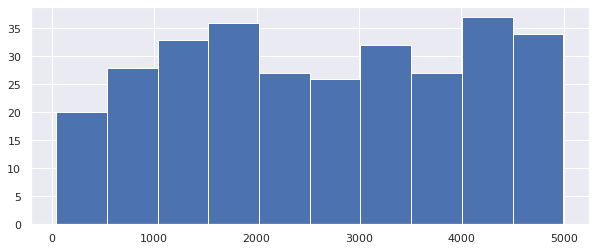

In [108]:
# column 0
train_transformed[0].hist(
    figsize=(10, 4),
);


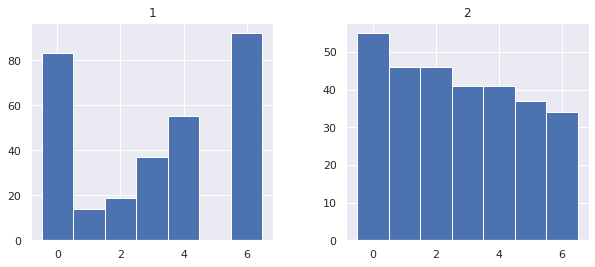

In [109]:
# columns 1, 2
train_transformed[[1, 2]].hist(
    figsize=(10, 4),
    bins=[x - 0.5 for x in range(8)]
);

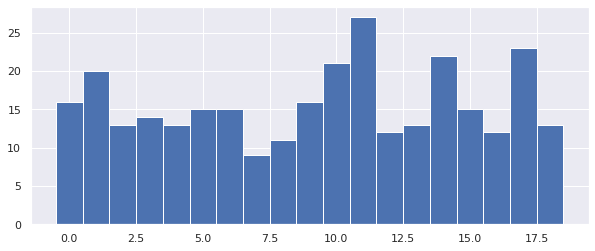

In [111]:
# print(f"column 3:")
train_transformed[3].hist(
    figsize=(10, 4),
    bins=[x - 0.5 for x in range(20)],
);

### Feature Label split

In [30]:
X_train = train_data.iloc[:, :-1].to_numpy()
y_train = train_data.iloc[:, -1].to_numpy()

print(f"Shape of train features: {X_train.shape}")
print(f"Shape of train labels: {y_train.shape}")

X_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

print(f"Shape of test features: {X_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

Shape of train features: (300, 4)
Shape of train labels: (300,)
Shape of test features: (120, 4)
Shape of test labels: (120,)


### Normalize Data

In [ ]:
X_train = np.sqrt(np.sum(X_train))